# Notebook to show different dynamic ranges of atlases

## Import libraries

In [45]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import scanpy
import scanpy.api as sc
from matplotlib import pyplot as plt
from sklearn import preprocessing
#sc.settings.figdir = '/work/sduknn/Andreas/TM_MCA/figures'
sc.settings.figdir = '/work/sduknn/Andreas/TM_MCA/new_new_figures2'
output_dir = "/work/sduknn/Andreas/TM_MCA/new_new_figures2"
import matplotlib

In [46]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
scanpy.api.set_figure_params(scanpy=True, dpi=80, dpi_save=1200, frameon=True, vector_friendly=True)

In [47]:
#Read colormap
colormap = pd.read_csv('data/ColorMap.csv', sep=';')

# Loading datasets

## Pseudobulk datasets

### Loading and preprocessing

In [48]:
from RegulonPreprocessing import preprocess_pb

In [49]:
droplet, facs, mca = preprocess_pb('data')

Loading datasets
Subsetting genes (expressed in 10% of cells in all datasets)
Normalizing
Log transforming
Detecting highly variable genes
Regressing out: # counts and % mito
Scaling
Removing unannotated cells
Annotating datasets


### Annotating

In [53]:
mapper = {x:y for x,y in zip(colormap.celltype, colormap.Super_type)}

In [54]:
droplet.obs['Super'] = droplet.obs.celltype.map(mapper)
facs.obs['Super'] = facs.obs.celltype.map(mapper)
mca.obs['Super'] = mca.obs.celltype.map(mapper)


In [55]:
droplet.obs['method'] = 'TM - 10X'
facs.obs['method'] = 'TM - SS2'
mca.obs['method'] = 'MCA'

In [56]:
merge = sc.AnnData.concatenate(droplet, facs, mca, join = 'inner')

### Plotting cell group proportions

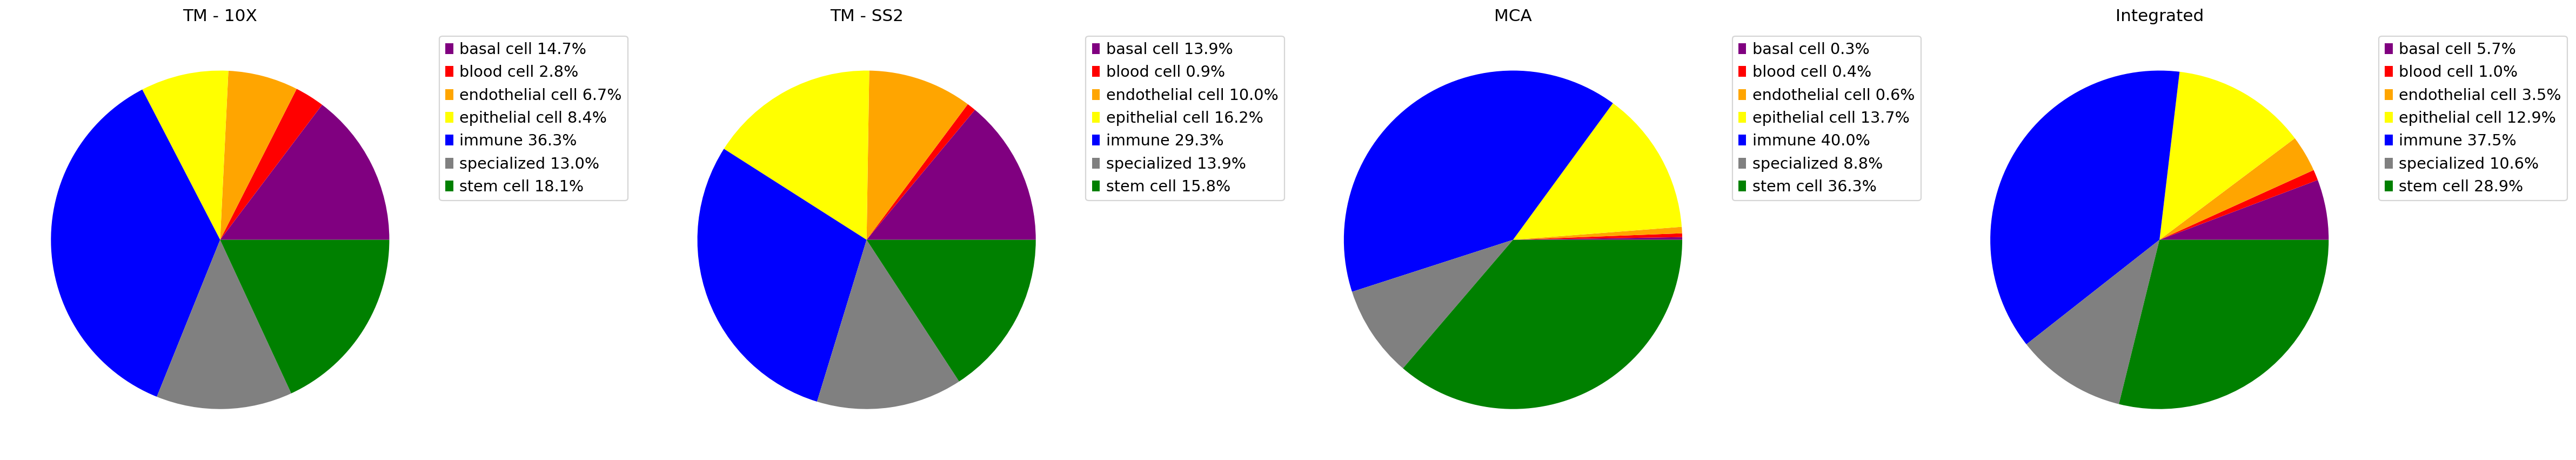

In [10]:
pal = {x:y for x,y in zip(colormap.Super_type, colormap.color_cat)}

fig, axs = plt.subplots(1, 4, figsize = (30,10), sharey = 'row')
axs = np.ravel(axs)

def plot_pie(data_set, ax):
    data = [float(x) for x in data_set.obs.groupby('Super').count()['method']]
    label = [x for x in data_set.obs.groupby('Super').count()['method'].index]

    total = np.sum(data)


    def func(pct, allvals):
        return "{:.1f}%".format(pct)
    wedges,autotexts = ax.pie(data, #autopct=lambda pct: func(pct, data),
                                      #textprops=dict(color="w"), 
                                      colors = [pal[x] for x in label])
    
    ax.legend(labels=[f'{x} {np.round(y/np.sum(data)*100,1)}%' for x,y in zip(label, data)], 
           bbox_to_anchor=(1,1))

    
plot_pie(droplet, axs[0])
plot_pie(facs, axs[1])
plot_pie(mca, axs[2])
plot_pie(merge, axs[3])
axs[0].set_title('TM - 10X')
axs[1].set_title('TM - SS2')
axs[2].set_title('MCA')
axs[3].set_title('Integrated')
plt.tight_layout()

plt.show()
#plt.savefig('figures/pies_pb.pdf')
plt.close()

In [59]:
#Store the number of cells per cell group
merge.obs['Cell_id'] = range(len(merge.obs.Super))
pb_count = pd.DataFrame(merge.obs.groupby('Super').count()['Cell_id'])
pb_count.columns = ['PB']

,PB
Super,
basal cell,261
blood cell,46
endothelial cell,158
epithelial cell,584
immune,1702
specialized,479
stem cell,1310


## Single cell datasets

### Loading and annotating

In [11]:
droplet = sc.read('data/tm_droplet_scanpy_no_processing.h5ad')
facs = sc.read('data/tm_facs_scanpy_no_processing.h5ad')
mca = sc.read('data/mca_scanpy_no_processing.h5ad')


#getting annotation from scmap projection of droplet
mca_ann = pd.read_csv('data/mca_annotation_projected_from_drop.tsv', sep= '\t')

facs_ann = pd.read_csv('data/facs_annotation_projected_from_drop.tsv', sep= '\t')

#getting annotation from scmap projection of droplet

mca.obs['original_annotation'] =  mca_ann['original'].values
mca.obs['from_droplet'] =  mca_ann['projected_drom_droplet'].values

facs.obs['original_annotation'] =  facs_ann['original'].values
facs.obs['from_droplet'] =  facs_ann['projected_drom_droplet'].values
mca.obs['method'] = 'MCA'

In [12]:
mapper = {x:y for x,y in zip(colormap.celltype, colormap.Super_type)}

In [13]:
droplet.obs['Super'] = droplet.obs.cell_ontology_class.map(mapper)
facs.obs['Super'] = facs.obs.from_droplet.map(mapper)
mca.obs['Super'] = mca.obs.from_droplet.map(mapper)



droplet.obs['celltype'] = droplet.obs['cell_ontology_class']
facs.obs['celltype'] = facs.obs['from_droplet']
mca.obs['celltype'] = mca.obs['from_droplet']

### Removing un-annotated cells

In [14]:
print(droplet.n_obs)
print(facs.n_obs)
print(mca.n_obs)

70118
53760
233994


In [15]:
droplet.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)
facs.obs['cell_ontology_class'].replace(np.NaN, 'Non-annotated', inplace = True)
mca.obs['original_annotation'].replace(np.NaN, 'Non-annotated', inplace = True)

In [16]:
droplet = droplet[droplet.obs['cell_ontology_class'] != 'Non-annotated']
facs = facs[facs.obs['cell_ontology_class'] != 'Non-annotated']
facs = facs[facs.obs['from_droplet'] != 'unassigned']
mca = mca[mca.obs['original_annotation'] != 'Non-annotated']
mca = mca[mca.obs['from_droplet'] != 'unassigned']

In [17]:
print(droplet.n_obs)
print(facs.n_obs)
print(mca.n_obs)

54865
38888
150889


### Compute quantitative statistics

In [18]:
for i in [facs, droplet, mca]:
    i.obs['n_counts'] = i.X.sum(axis=1).A1
    sc.pp.calculate_qc_metrics(i, inplace = True)

In [19]:
merge = sc.AnnData.concatenate(droplet, facs, mca, join = 'inner')

### Plotting quantitative statistics

In [34]:
#Plots categorical scatterplots with boxplots
def plot(adata, feature, groupby, ax, pal , hue = 'Super'):
    order = ['immune',
         'specialized',
         'stem cell',
         'endothelial cell',
         'basal cell', 
         'blood cell',
         'epithelial cell']
    sns.stripplot(y = feature, x = groupby, data = adata.obs, ax = ax, hue = hue, palette = pal, alpha = 0.2, rasterized=True,
                 order = order)
    
    sns.boxplot(x=groupby, y=feature, data=adata.obs, color='white', width=.5, fliersize=0, ax = ax,  order = order,
                boxprops={'facecolor':'None', "zorder":10},
                                                          showfliers=False,whiskerprops={'linewidth':1, "zorder":10},
                                                          zorder=10)
    
    medians = adata.obs.groupby([groupby])[feature].median()
    vertical_offset = adata.obs[feature].max() * 1.05 # offset from median for display
    
    for idx, xtick in enumerate(order):
        ax.text(idx,int(medians[xtick]) + vertical_offset, int(medians[xtick]), 
                      horizontalalignment='center',size='x-small',color='k',
                #weight='semibold', 
                rotation=45)
    
    
    ax.set_yscale('log')
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_xticks([])

    
def plot_ct(adata, feature, groupby, ax, pal , order, hue = 'Super'):
    sns.stripplot(y = feature, x = groupby, data = adata.obs, ax = ax, hue = hue, palette = pal, alpha = 0.2, order = order, rasterized=True)
    
    sns.boxplot(x=groupby, y=feature, data=adata.obs, color='white', width=.5, fliersize=0, ax = ax, order = order,
                boxprops={'facecolor':'None', "zorder":10},
                                                          showfliers=False,whiskerprops={'linewidth':1, "zorder":10},
                                                          zorder=10)
    
    
    ax.set_yscale('log')
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_xticks([])
    

In [21]:
pal = {x:y for x,y in zip(colormap.Super_type, colormap.color_cat)}

In [22]:
pal_grad = {x:y for x,y in zip(colormap.celltype, colormap.color_grad)}

In [23]:
order = ['immune',
         'specialized',
         'stem cell',
         'endothelial cell',
         'basal cell', 
         'blood cell',
         'epithelial cell']

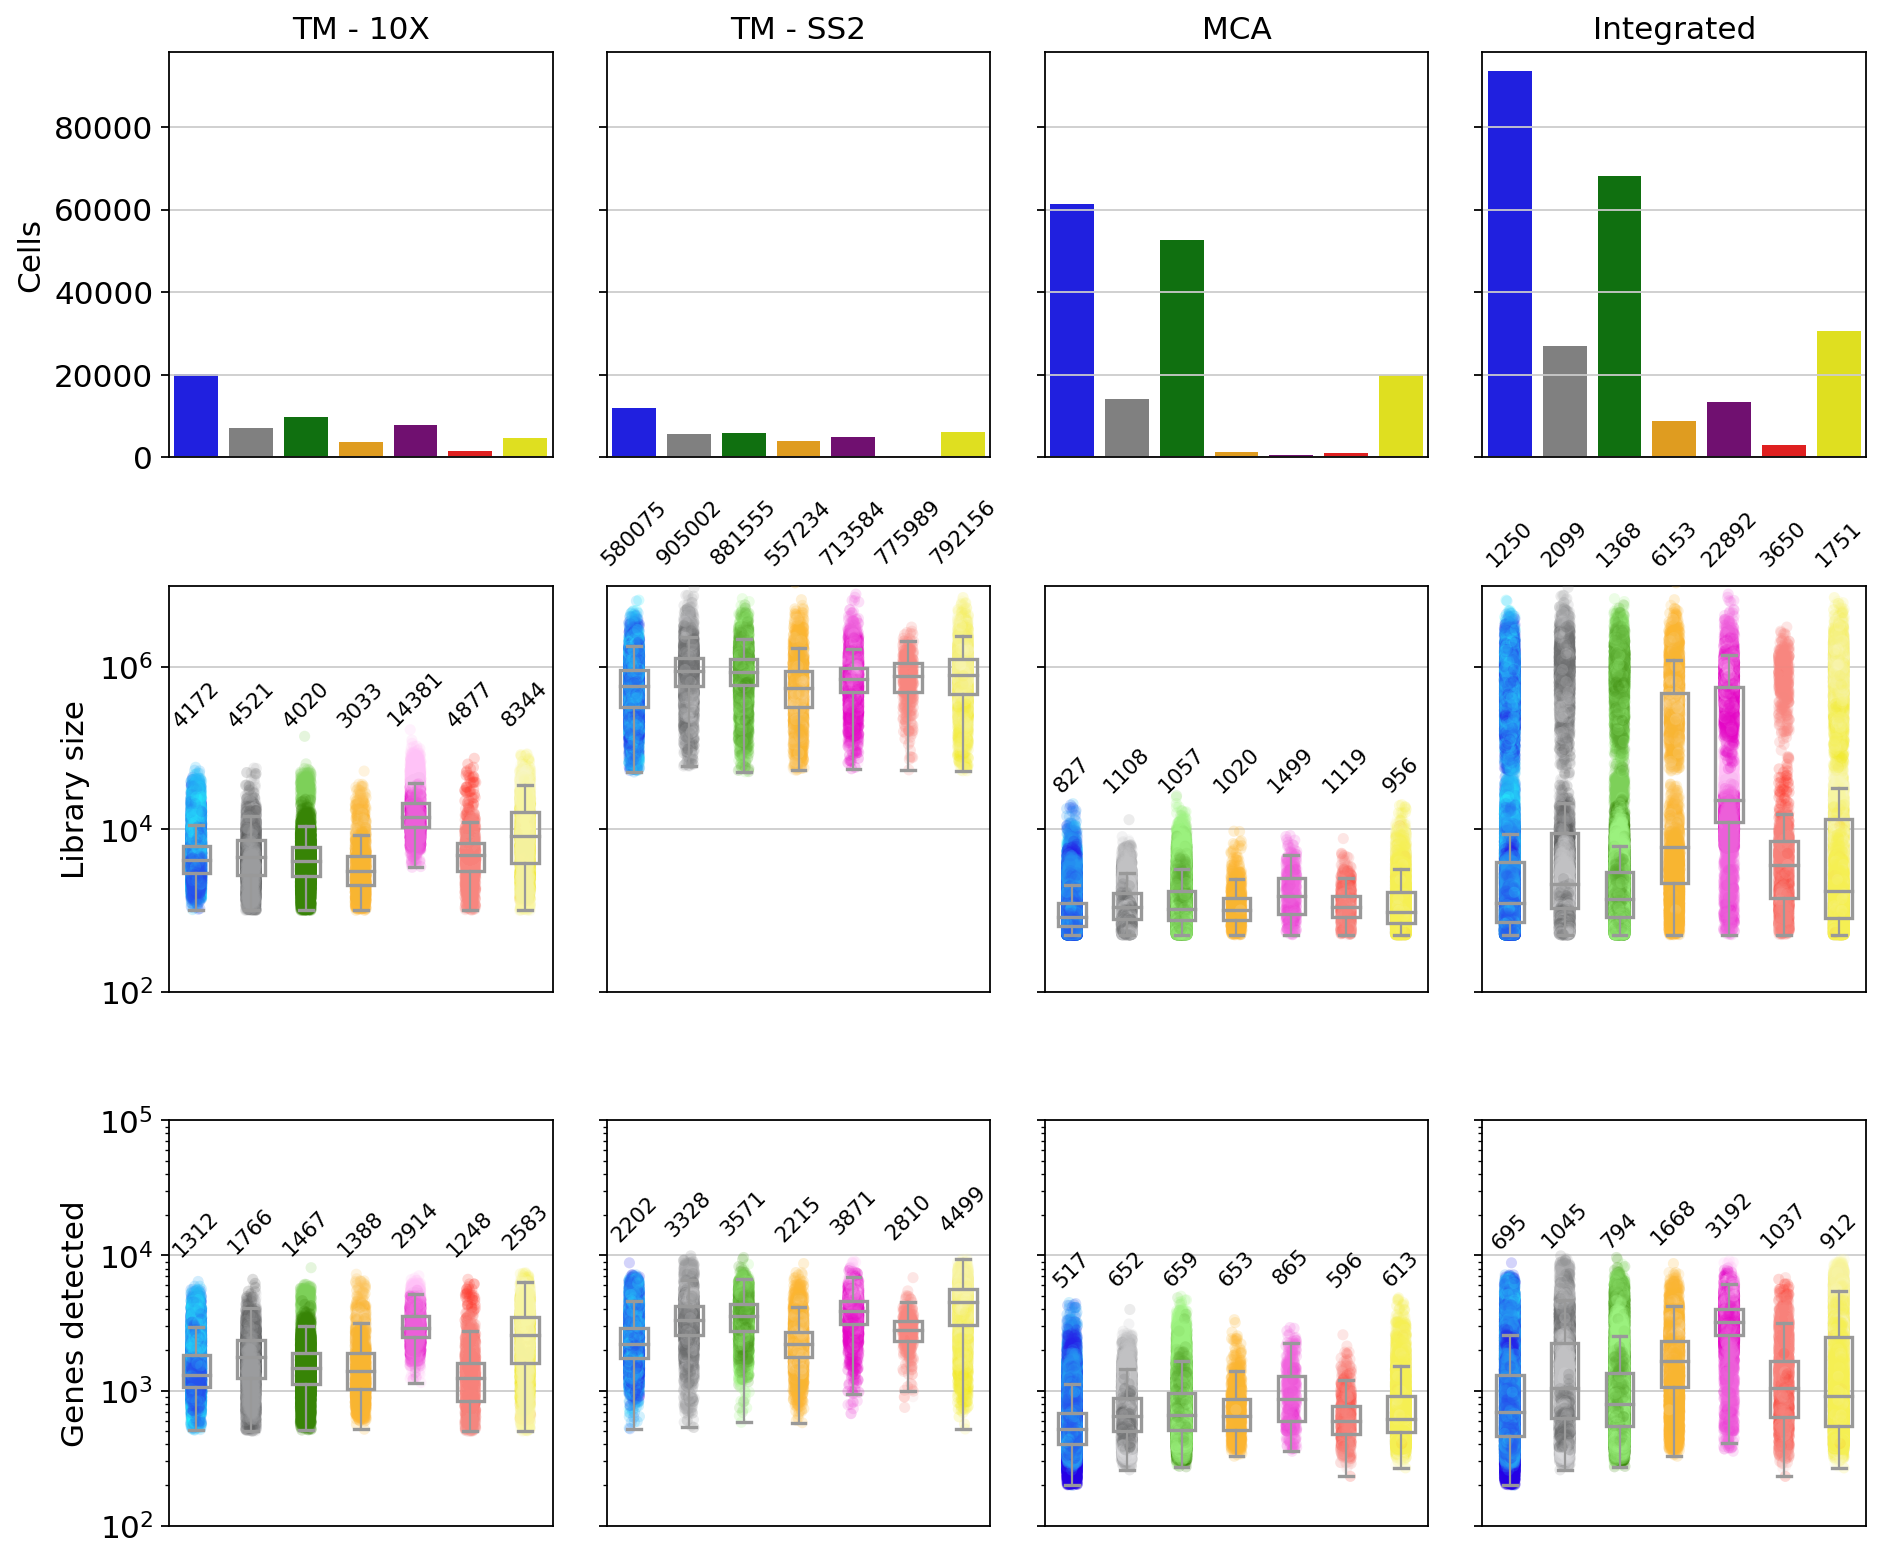

In [35]:
fig, axs = plt.subplots(3, 4, figsize = (12,10), sharey = 'row')
axs = np.ravel(axs)

sns.barplot(x = 'Super', y = 'method',data = pd.DataFrame(droplet.obs.groupby('Super').count()['method']).reset_index(), ax = axs[0], palette = pal, order = order)
sns.barplot(x = 'Super', y = 'method',data = pd.DataFrame(facs.obs.groupby('Super').count()['method']).reset_index(), ax = axs[1], palette = pal, order = order)
sns.barplot(x = 'Super', y = 'method',data = pd.DataFrame(mca.obs.groupby('Super').count()['method']).reset_index(), ax = axs[2], palette = pal, order = order)
sns.barplot(x = 'Super', y = 'method',data = pd.DataFrame(merge.obs.groupby('Super').count()['method']).reset_index(), ax = axs[3], palette = pal, order = order)
axs[0].set_title('TM - 10X')
axs[1].set_title('TM - SS2')
axs[2].set_title('MCA')
axs[3].set_title('Integrated')

axs[0].set_xlabel('')
axs[0].set_xticks([])
axs[1].set_xlabel('')
axs[1].set_xticks([])
axs[2].set_xlabel('')
axs[2].set_xticks([])
axs[3].set_xlabel('')
axs[3].set_xticks([])

axs[0].set_ylabel('Cells')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[3].set_ylabel('')



plot(droplet, 'n_counts', 'Super', ax = axs[4], hue = 'cell_ontology_class', pal = pal_grad)
plot(facs, 'n_counts', 'Super', ax = axs[5], hue = 'from_droplet', pal = pal_grad)
plot(mca, 'n_counts', 'Super', ax = axs[6], hue = 'from_droplet', pal = pal_grad)
plot(merge, 'n_counts', 'Super', ax = axs[7], hue = 'celltype', pal = pal_grad)
axs[4].set_ylim(100,10000000)
axs[5].set_ylim(100,10000000)
axs[6].set_ylim(100,10000000)
axs[7].set_ylim(100,10000000)
axs[4].set_ylabel('Library size')
axs[5].set_ylabel('')
axs[6].set_ylabel('')
axs[7].set_ylabel('')

plot(droplet, 'n_genes_by_counts', 'Super', ax = axs[8], hue = 'cell_ontology_class', pal = pal_grad)
plot(facs, 'n_genes_by_counts', 'Super', ax = axs[9], hue = 'from_droplet', pal = pal_grad)
plot(mca, 'n_genes_by_counts', 'Super', ax = axs[10], hue = 'from_droplet', pal = pal_grad)
plot(merge, 'n_genes_by_counts', 'Super', ax = axs[11], hue = 'celltype', pal = pal_grad)
axs[8].set_ylim(100,100000)
axs[9].set_ylim(100,100000)
axs[10].set_ylim(100,100000)
axs[11].set_ylim(100,100000)
axs[8].set_ylabel('Genes detected')
axs[9].set_ylabel('')
axs[10].set_ylabel('')
axs[11].set_ylabel('')

plt.tight_layout()
plt.savefig('figures/quant_sc_global.pdf')









### Plotting cell group proportions

In [29]:
fig, axs = plt.subplots(1, 4, figsize = (30,10), sharey = 'row')
axs = np.ravel(axs)

def plot_pie(data_set, ax):
    data = [float(x) for x in data_set.obs.groupby('Super').count()['method']]
    label = [x for x in data_set.obs.groupby('Super').count()['method'].index]

    total = np.sum(data)
    def func(pct, allvals):
        return "{:.1f}%".format(pct)
    wedges, autotexts = ax.pie(data, #autopct=lambda pct: func(pct, data),
                                      #textprops=dict(color="w"), 
                                      colors = [pal[x] for x in label])
    ax.legend(labels=[f'{x} {np.round(y/np.sum(data)*100,1)}%' for x,y in zip(label, data)], 
           bbox_to_anchor=(1,1))
    
plot_pie(droplet, axs[0])
plot_pie(facs, axs[1])
plot_pie(mca, axs[2])
plot_pie(merge, axs[3])
axs[0].set_title('TM - 10X')
axs[1].set_title('TM - SS2')
axs[2].set_title('MCA')
axs[3].set_title('Integrated')
plt.tight_layout()


plt.savefig('figures/pies_sc.pdf')
plt.close()



In [ ]:
#Store the number of cells per cell group
merge.obs['Cell_id'] = range(len(merge.obs.Super))
sc_count = pd.DataFrame(merge.obs.groupby('Super').count()['Cell_id'])
sc_count.columns = ['SC']

#### Quantitative statistics per cell group

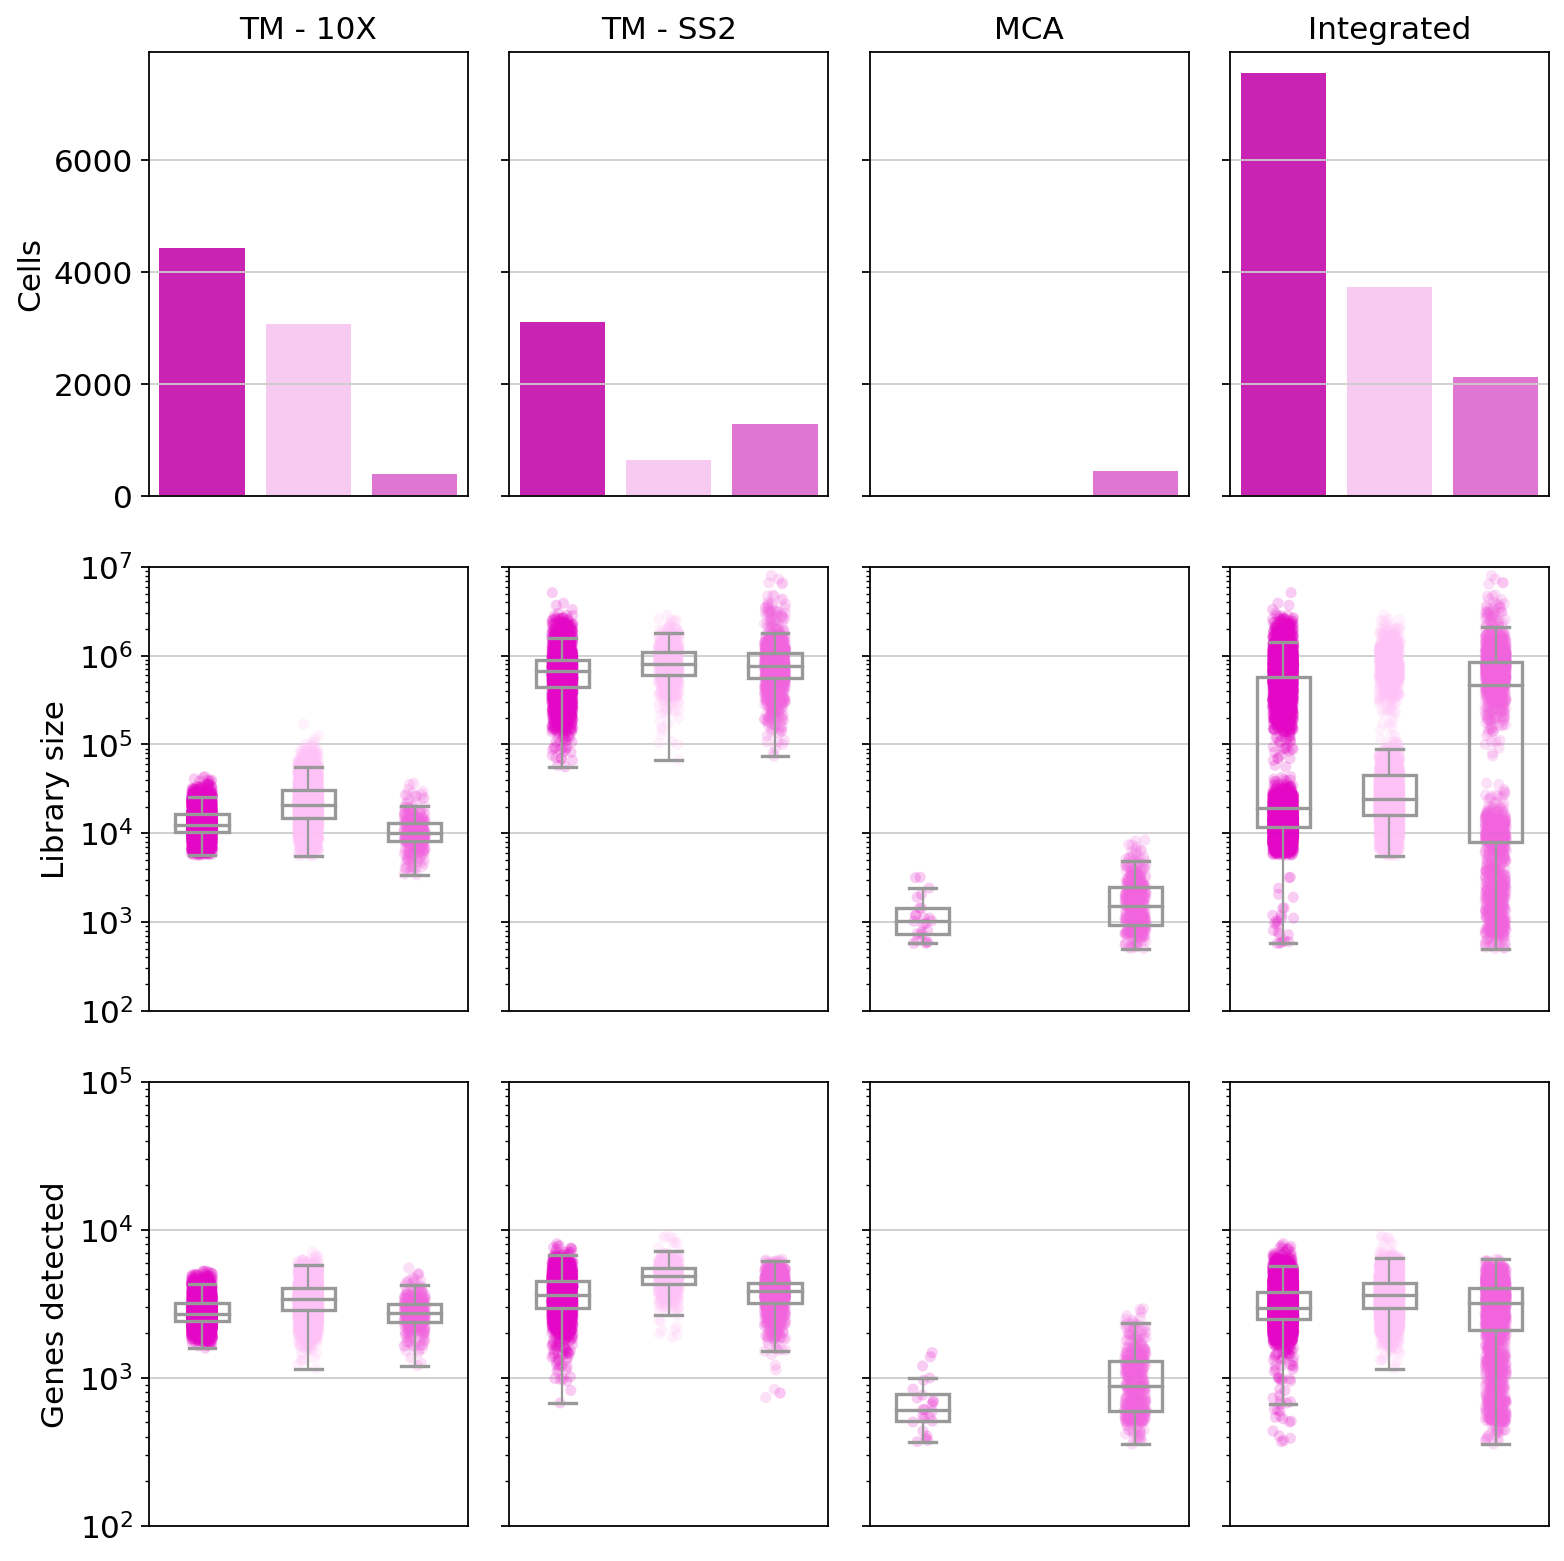

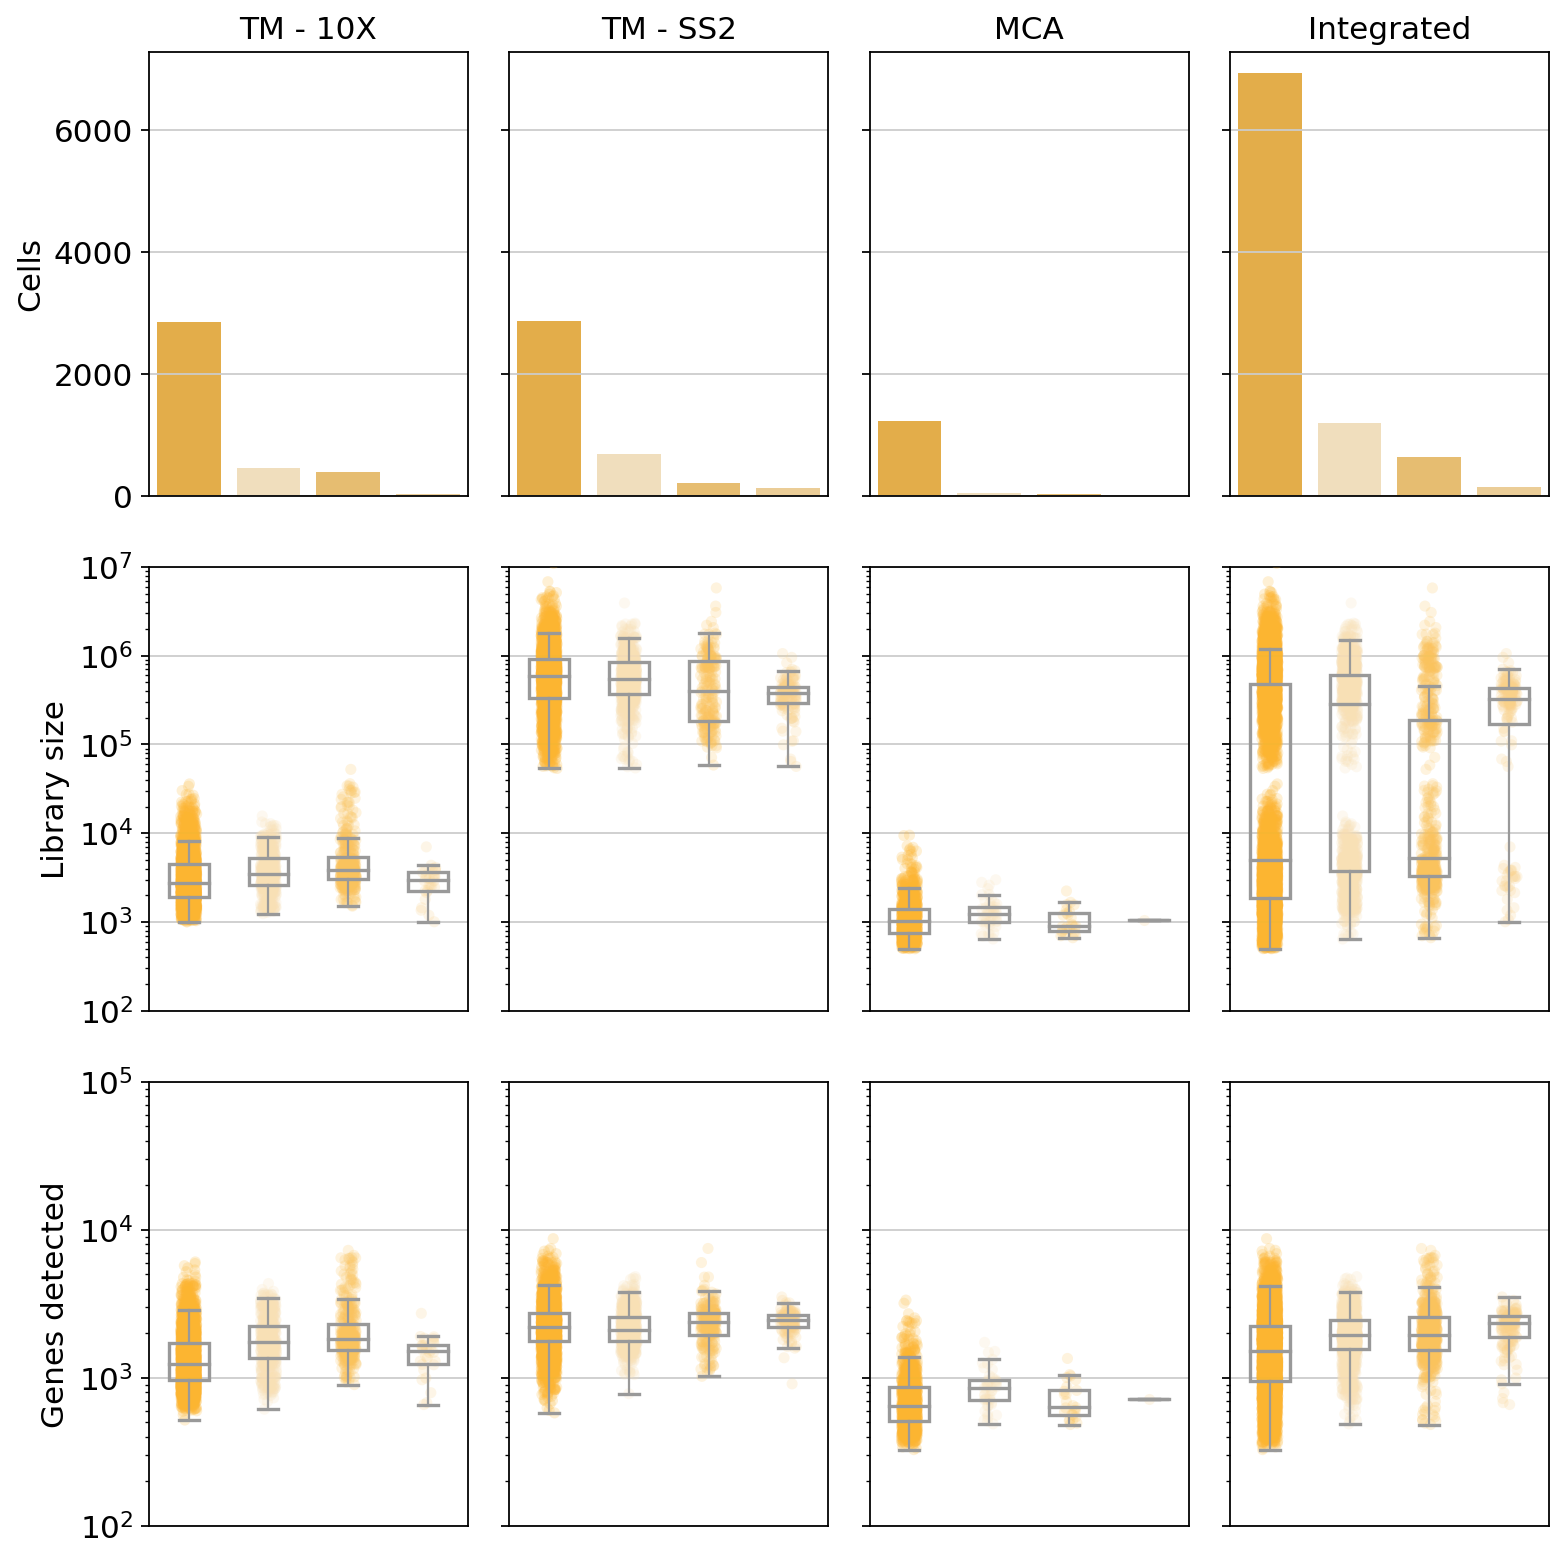

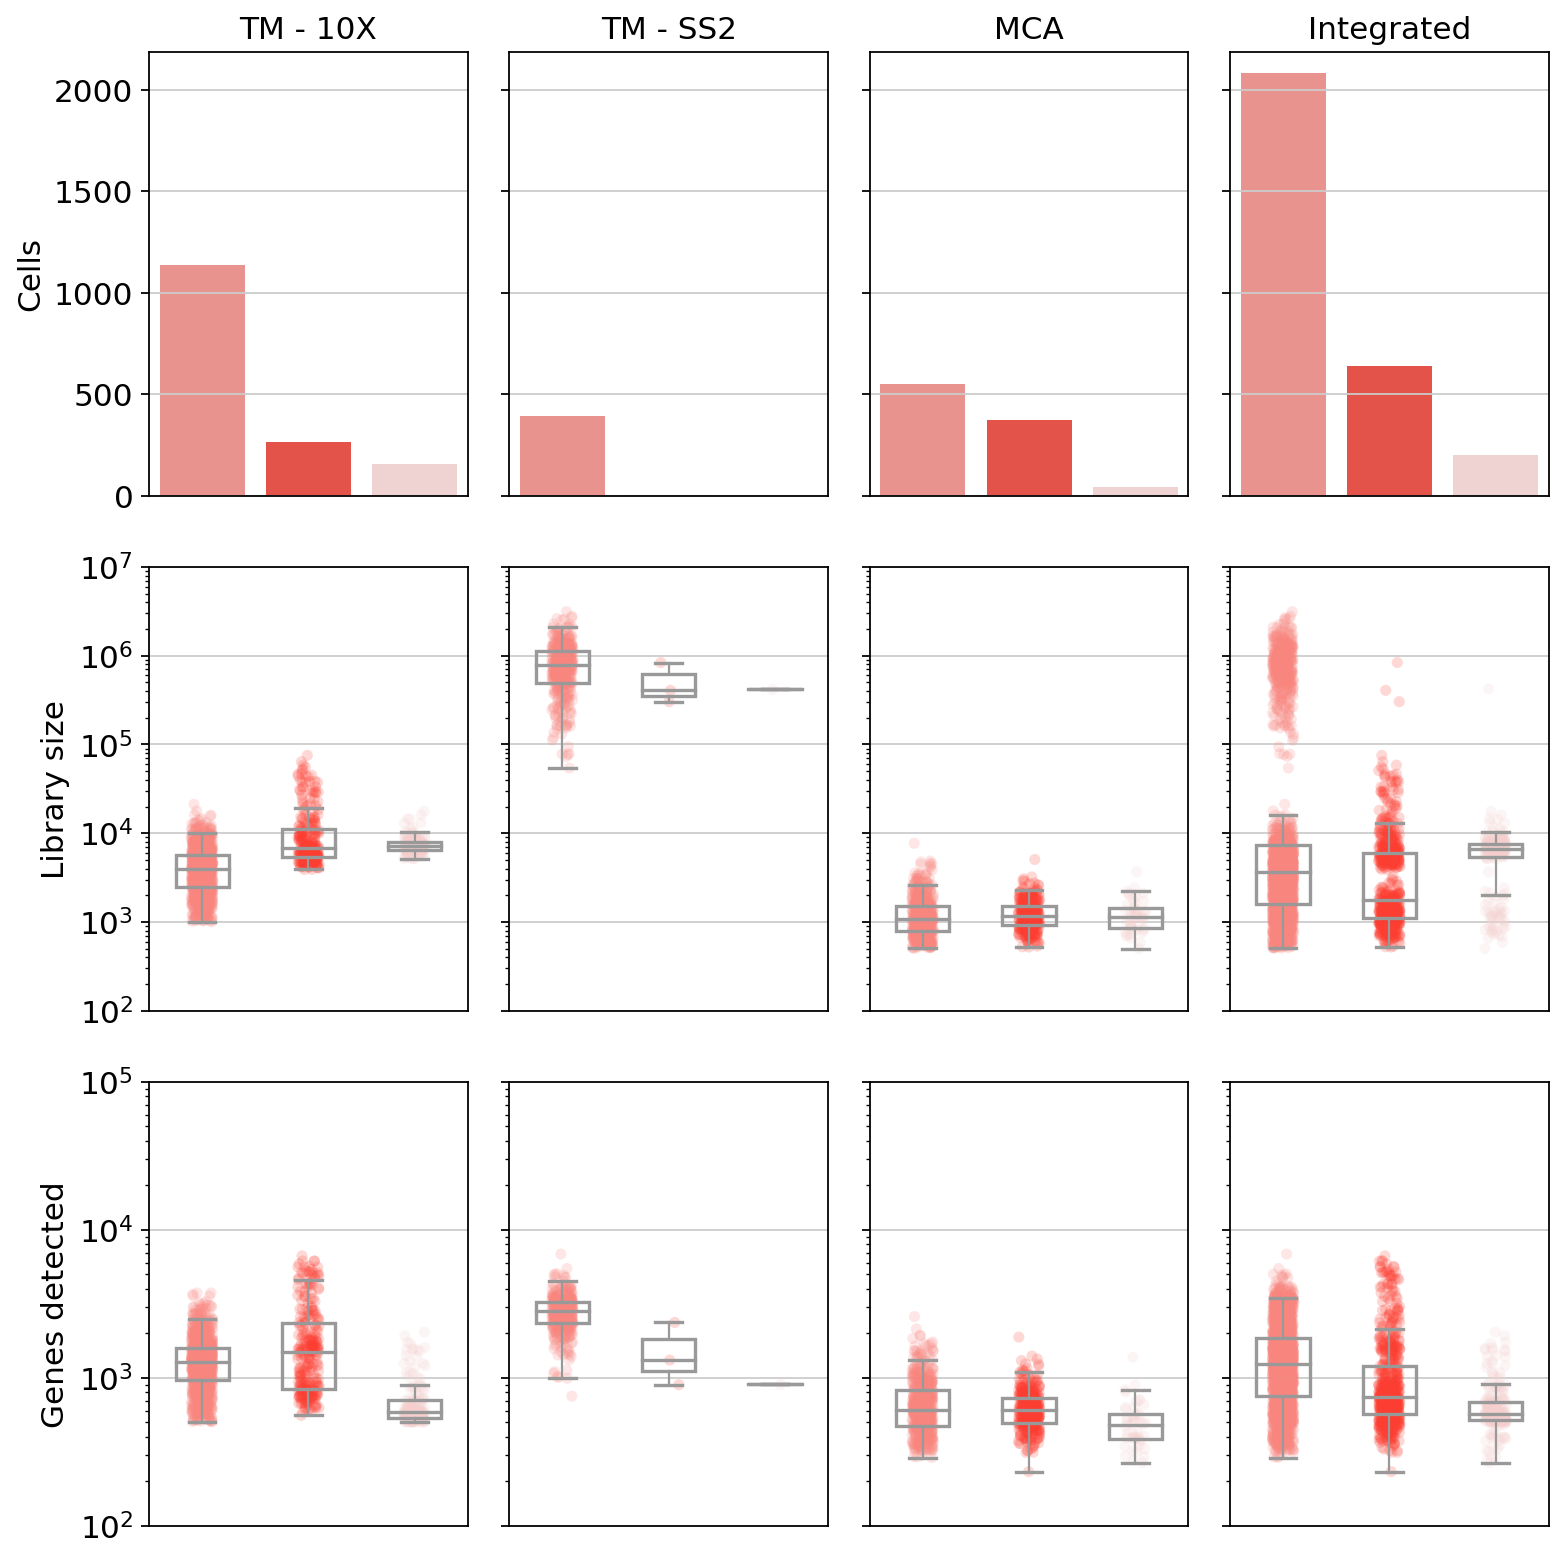

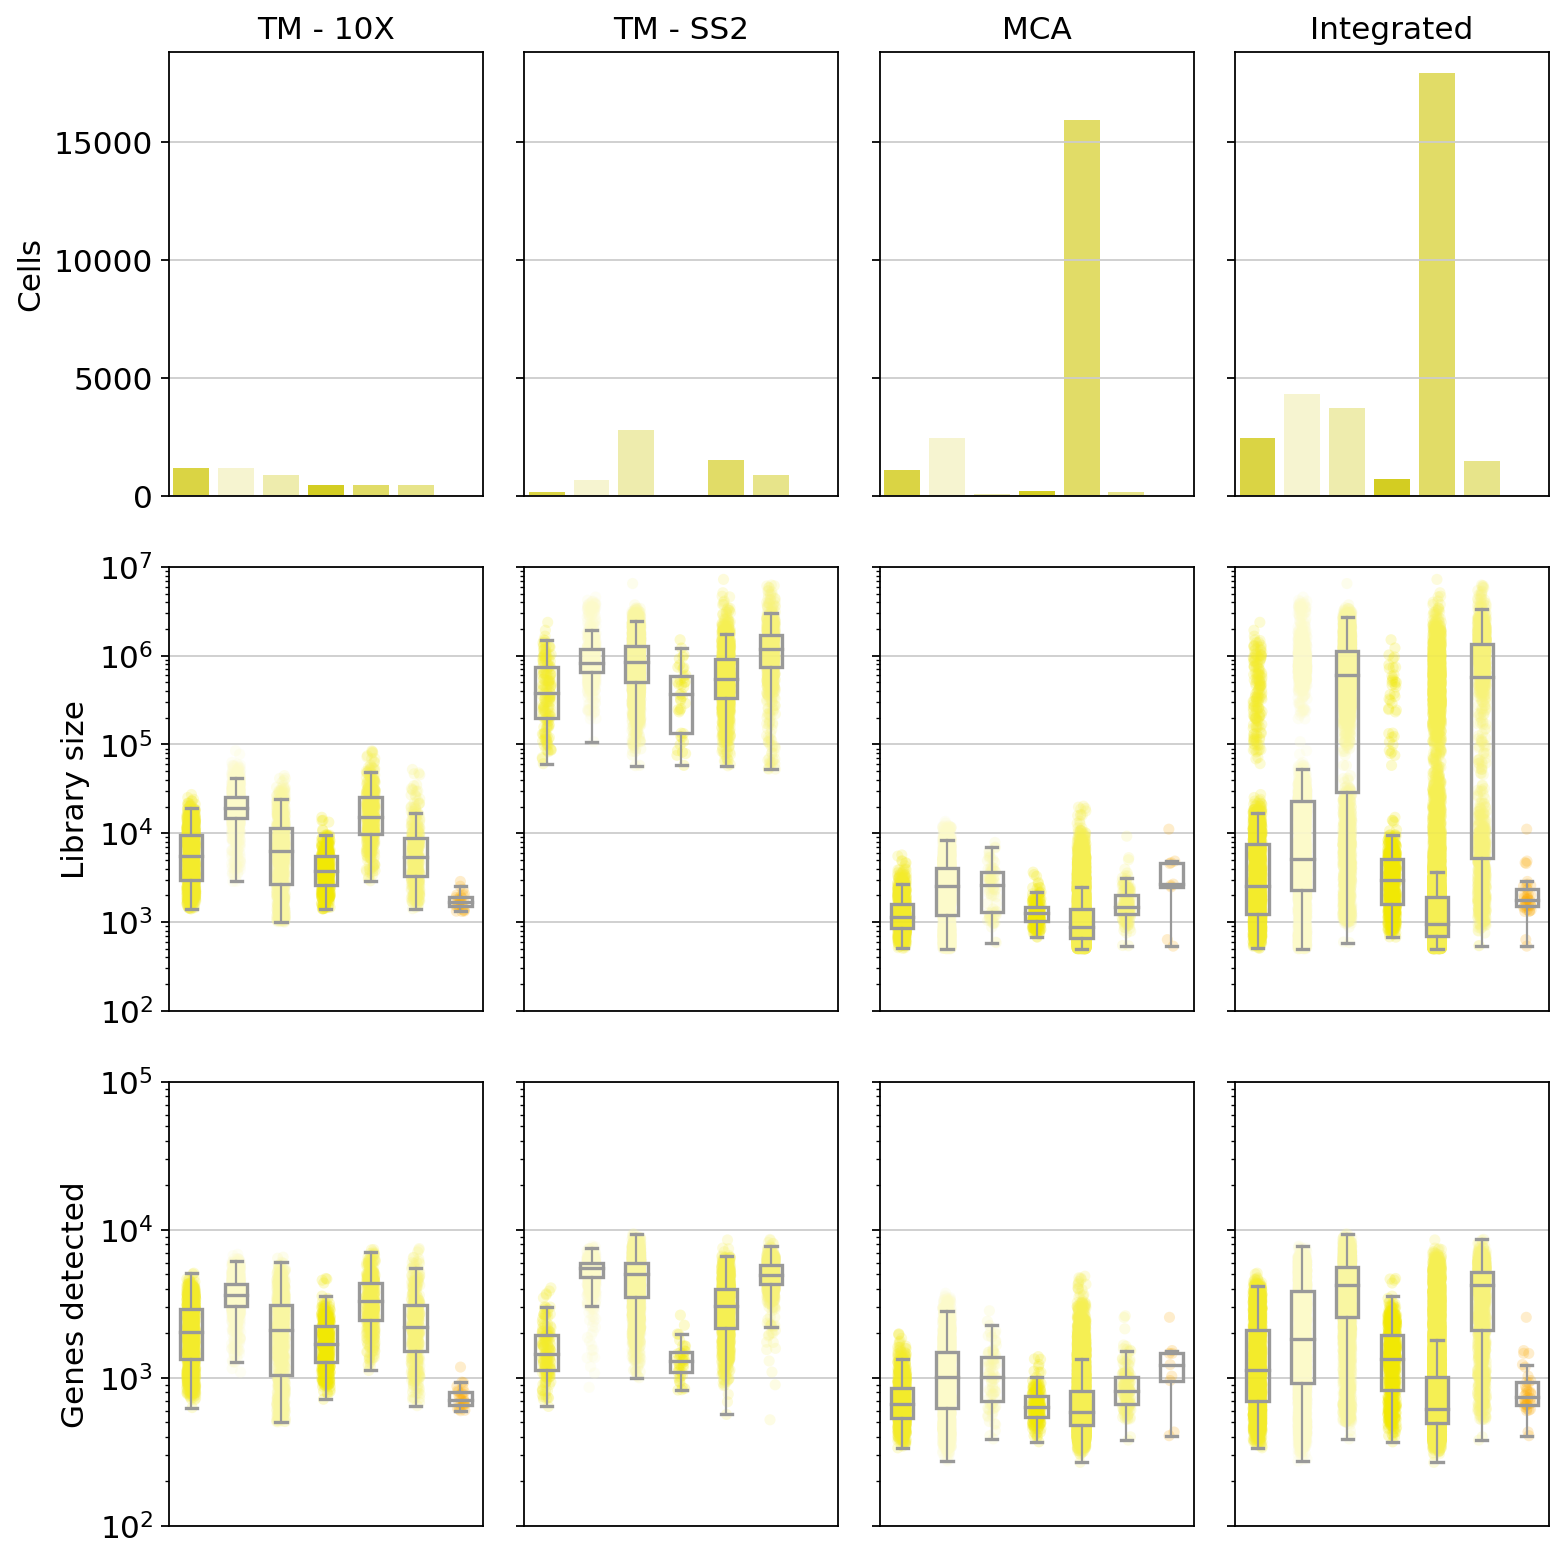

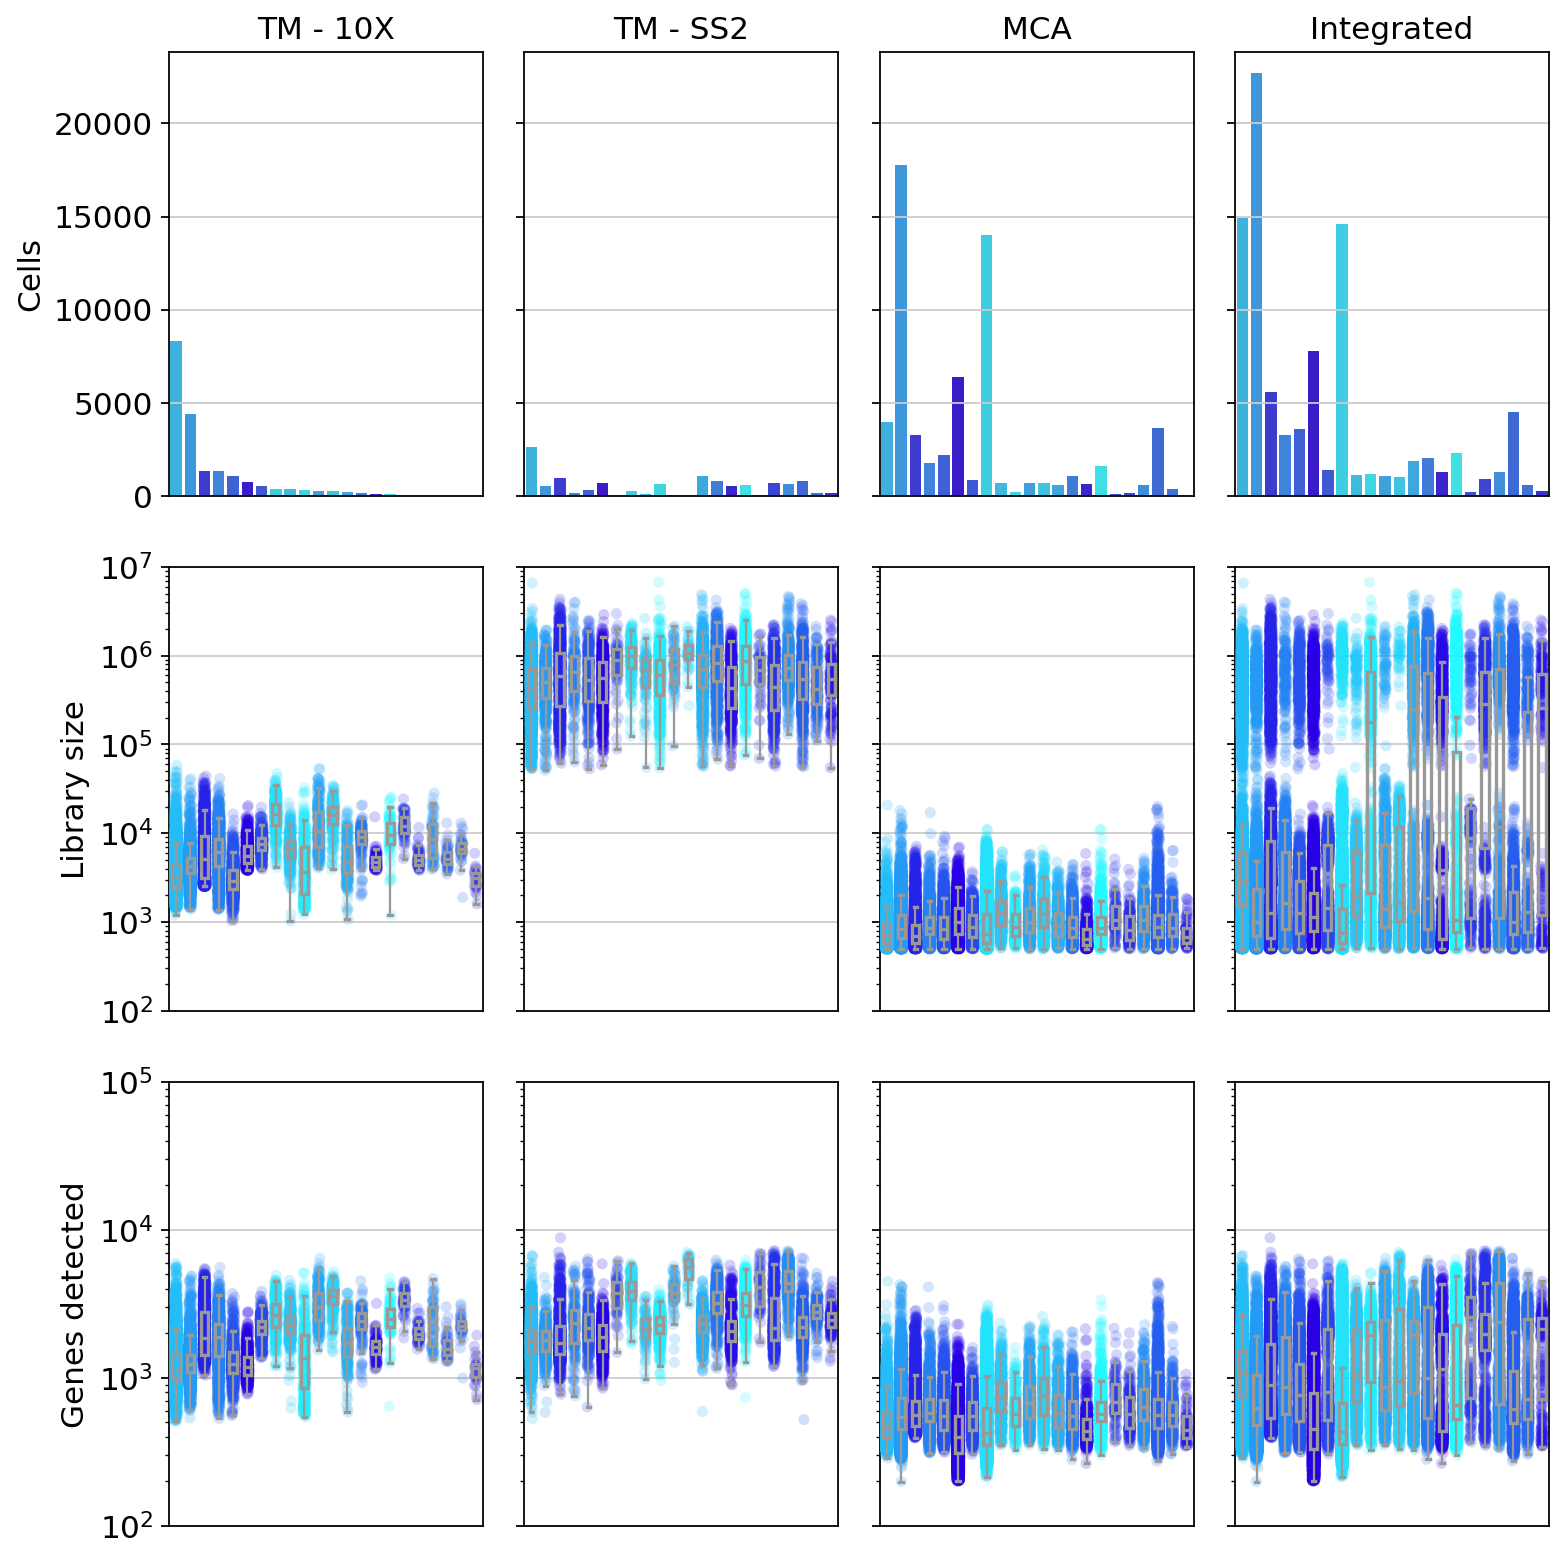

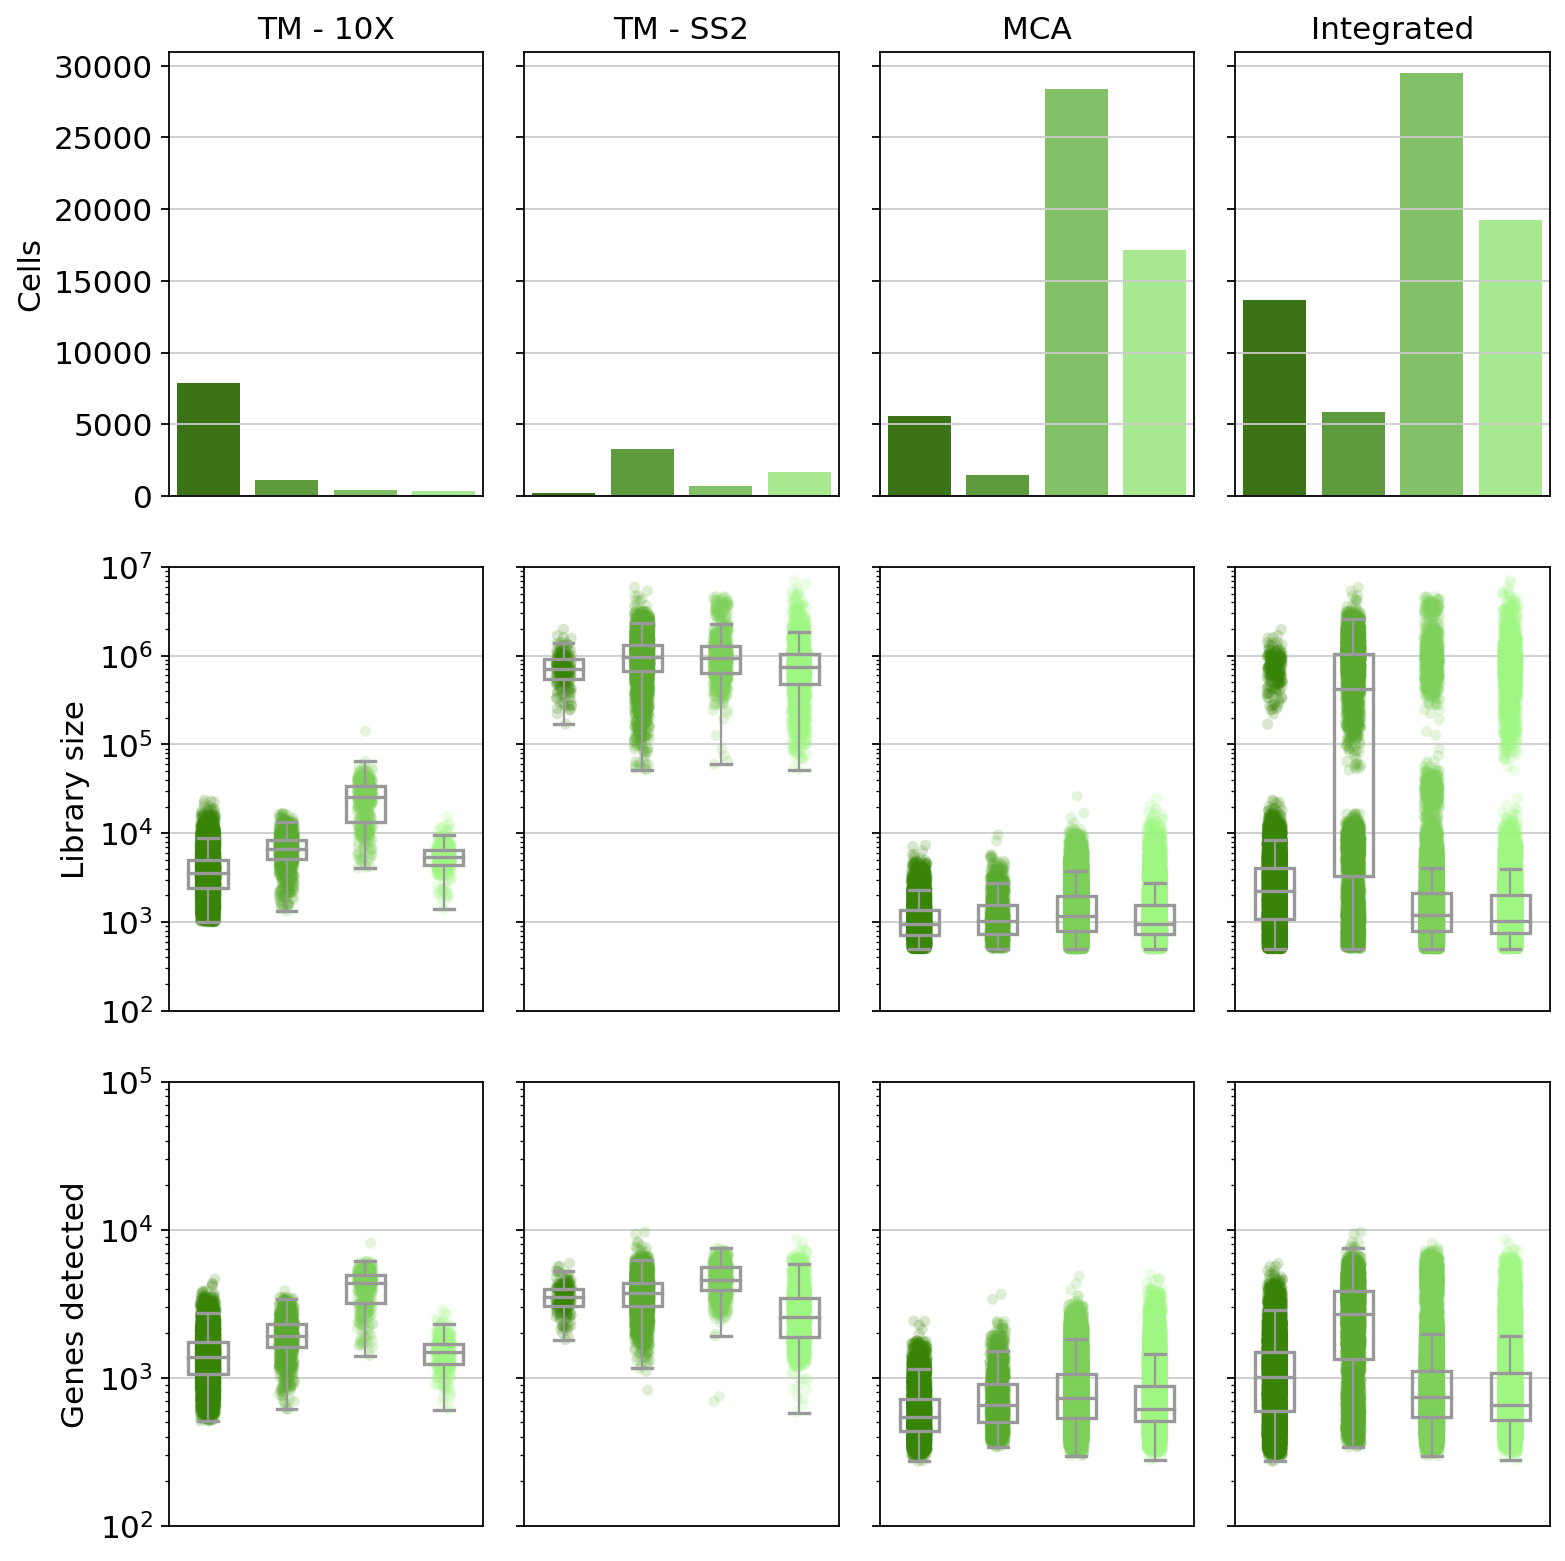

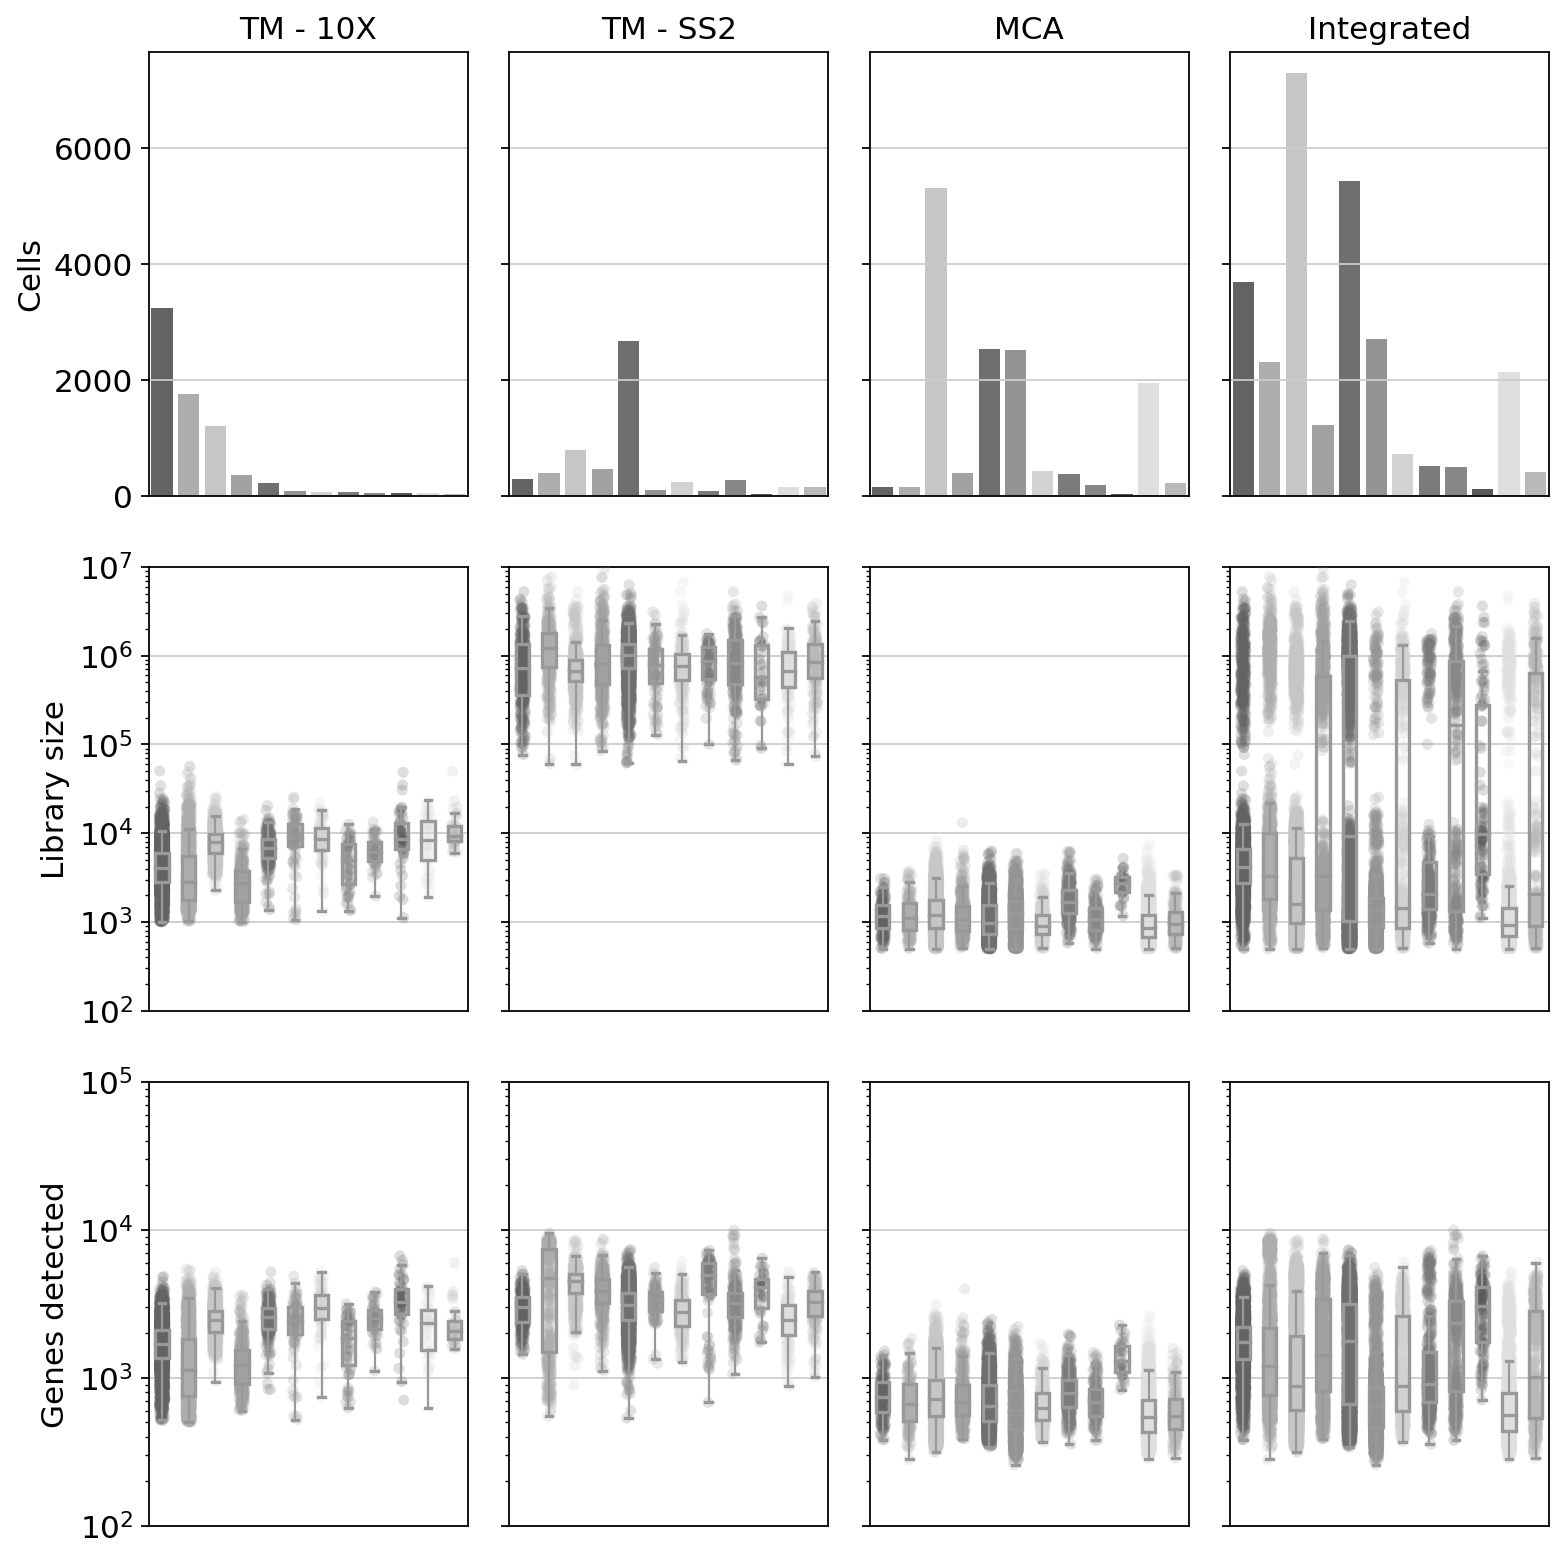

In [36]:
for ct in list(set(droplet.obs.Super)):
    droplet_sub = droplet[droplet.obs.Super == ct]
    facs_sub = facs[facs.obs.Super == ct]
    mca_sub = mca[mca.obs.Super == ct]
    merge_sub = merge[merge.obs.Super == ct]

    fig, axs = plt.subplots(3, 4, figsize = (10,10), sharey = 'row')
    axs = np.ravel(axs)
    order = pd.DataFrame(droplet_sub.obs.groupby('cell_ontology_class').count()['method']).reset_index().sort_values('method', ascending = False)['cell_ontology_class'].tolist()

    sns.barplot(x = 'cell_ontology_class', y = 'method',data = pd.DataFrame(droplet_sub.obs.groupby('cell_ontology_class').count()['method']).reset_index(), ax = axs[0], palette = pal_grad, order = order)
    sns.barplot(x = 'from_droplet', y = 'method',data = pd.DataFrame(facs_sub.obs.groupby('from_droplet').count()['method']).reset_index(), ax = axs[1], palette = pal_grad, order = order)
    sns.barplot(x = 'from_droplet', y = 'method',data = pd.DataFrame(mca_sub.obs.groupby('from_droplet').count()['method']).reset_index(), ax = axs[2], palette = pal_grad, order = order)
    sns.barplot(x = 'celltype', y = 'method',data = pd.DataFrame(merge_sub.obs.groupby('celltype').count()['method']).reset_index(), ax = axs[3], palette = pal_grad, order = order)
    axs[0].set_title('TM - 10X')
    axs[1].set_title('TM - SS2')
    axs[2].set_title('MCA')
    axs[3].set_title('Integrated')

    axs[0].set_xlabel('')
    axs[0].set_xticks([])
    axs[1].set_xlabel('')
    axs[1].set_xticks([])
    axs[2].set_xlabel('')
    axs[2].set_xticks([])
    axs[3].set_xlabel('')
    axs[3].set_xticks([])
    
    axs[0].set_ylabel('Cells')
    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    axs[3].set_ylabel('')



    plot_ct(droplet_sub, 'n_counts', 'cell_ontology_class', ax = axs[4], hue = 'cell_ontology_class', pal = pal_grad, order = order)
    plot_ct(facs_sub, 'n_counts', 'from_droplet', ax = axs[5], hue = 'from_droplet', pal = pal_grad, order = order)
    plot_ct(mca_sub, 'n_counts', 'from_droplet', ax = axs[6], hue = 'from_droplet', pal = pal_grad, order = order)
    plot_ct(merge_sub, 'n_counts', 'celltype', ax = axs[7], hue = 'celltype', pal = pal_grad, order = order)
    axs[4].set_ylim(100,10000000)
    axs[5].set_ylim(100,10000000)
    axs[6].set_ylim(100,10000000)
    axs[7].set_ylim(100,10000000)
    axs[4].set_ylabel('Library size')
    axs[5].set_ylabel('')
    axs[6].set_ylabel('')
    axs[7].set_ylabel('')
    
    plot_ct(droplet_sub, 'n_genes_by_counts', 'cell_ontology_class', ax = axs[8], hue = 'cell_ontology_class', pal = pal_grad, order = order)
    plot_ct(facs_sub, 'n_genes_by_counts', 'from_droplet', ax = axs[9], hue = 'from_droplet', pal = pal_grad, order = order)
    plot_ct(mca_sub, 'n_genes_by_counts', 'from_droplet', ax = axs[10], hue = 'from_droplet', pal = pal_grad, order = order)
    plot_ct(merge_sub, 'n_genes_by_counts', 'celltype', ax = axs[11], hue = 'celltype', pal = pal_grad, order = order)
    axs[8].set_ylim(100,100000)
    axs[9].set_ylim(100,100000)
    axs[10].set_ylim(100,100000)
    axs[11].set_ylim(100,100000)
    axs[8].set_ylabel('Genes detected')
    axs[9].set_ylabel('')
    axs[10].set_ylabel('')
    axs[11].set_ylabel('')

    plt.tight_layout()
    plt.savefig('figures/quant_sc_{}.pdf'.format(ct))
    
    
    
    


In [61]:
#Table of cells per cell group
pd.concat([pb_count, sc_count], axis = 1)

,PB,SC
Super,,
basal cell,261,13394
blood cell,46,2925
endothelial cell,158,8913
epithelial cell,584,30660
immune,1702,93461
specialized,479,27078
stem cell,1310,68211


### Plotting dropout rates

In [90]:
mca.var['method'] = 'MCA'
droplet.var['method'] = 'TM - 10X'
facs.var['method'] = 'TM - SS2'

con = pd.concat([droplet.var.loc[droplet.var.total_counts > 0] , 
                 mca.var.loc[mca.var.total_counts > 0] ,
    
               facs.var.loc[facs.var.total_counts > 0] ])


In [91]:
con['log_mean'] = np.log10(con.mean_counts)

#### Binned by percentiles

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequenc

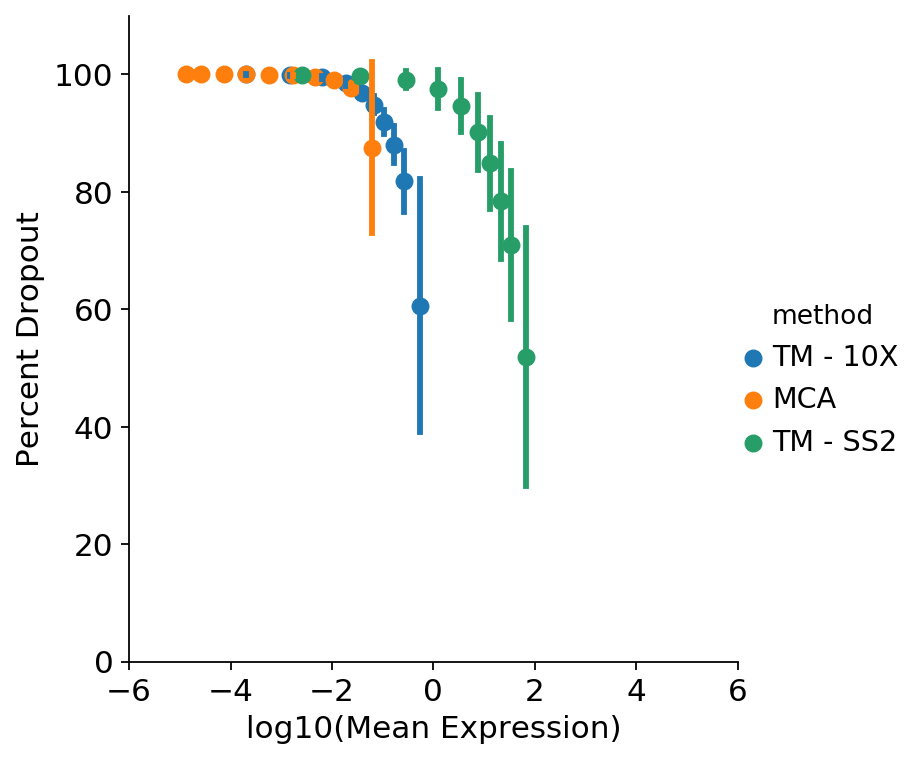

In [93]:

grid = sns.lmplot(x = 'log_mean',y =  'pct_dropout_by_counts', data = con, fit_reg = False , hue = 'method', scatter = True, x_bins = 10, x_ci = 'sd')
axes = grid.axes
plt.grid(False)
axes[0,0].set_ylim(0,110)
axes[0,0].set_xlim(-6,6)
axes[0,0].set_xlabel('log10(Mean Expression)')
axes[0,0].set_ylabel('Percent Dropout')
plt.savefig('figures/dropout_binned.pdf')

In [110]:
con['drop_rate'] = con['pct_dropout_by_counts'] / 100

#### With line fit

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequenc

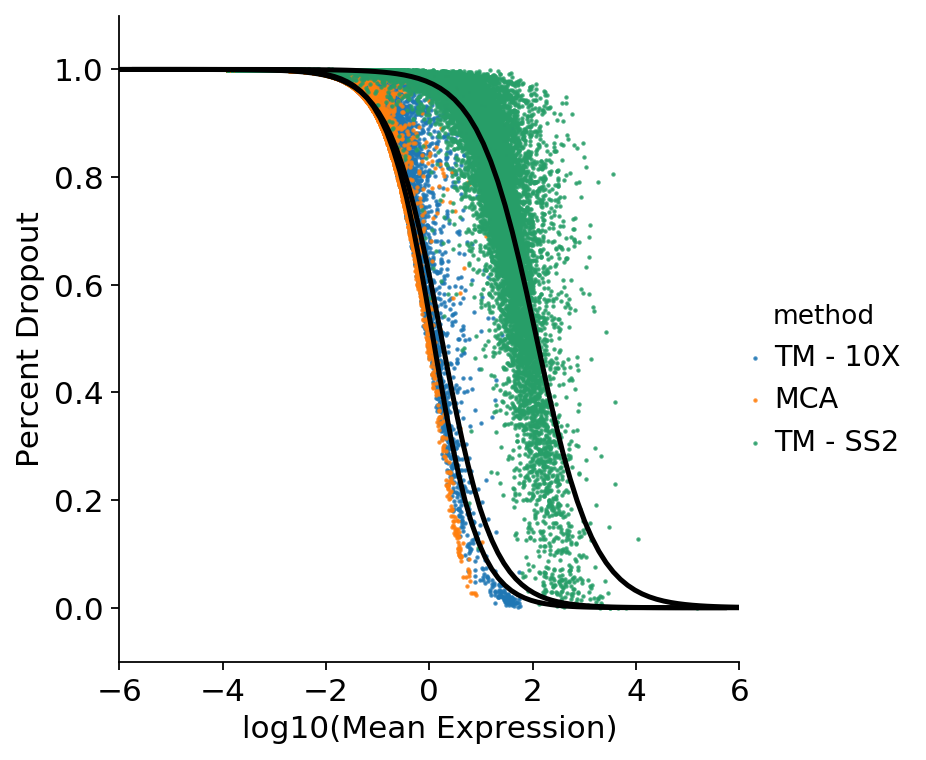

In [113]:

grid = sns.lmplot(x = 'log_mean',y =  'drop_rate', data = con, 
                  hue = 'method', 
                  scatter = True, 
                  lowess = False, 
                  line_kws = {'color':'black'}, 
                  robust = False, 
                  #order = 3,
                  logistic = True,
                  truncate = False,
                  scatter_kws = {'s':1, 'rasterized':True}
                 )
plt.grid(False)
axes = grid.axes
axes[0,0].set_ylim(-0.1,1.1)
axes[0,0].set_xlim(-6,6)
axes[0,0].set_xlabel('log10(Mean Expression)')
axes[0,0].set_ylabel('Percent Dropout')
plt.savefig('figures/dropout_scatter_regression.pdf')